# Determinación de puntos de interés en un mapa en Ecuador para el IVRP

<div class="alert alert-block alert-info">
Este cuadernillo está hecho para determinar puntos de intéres dentro de una red vehicular y pedestre. Esta información permitirá simular instancias con información real de movimiento.
</div>

In [1]:
# Gurobi
from gurobipy import *

In [2]:
# Packages
import numpy  as np
import pandas as pd
import time

import scipy.misc
import scipy.stats
from   scipy import misc
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.ticker as mticker

# Imprimir en notación decimal
np.set_printoptions(suppress=True)#np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# Manipulación de fechas
import datetime
import locale
locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8');

In [3]:
# Aliases
array, app, arange, zeros, unique, asarray = np.array, np.append, np.arange, np.zeros, np.unique, np.asarray
mean, take_along_axis = np.mean, np.take_along_axis
where, column_stack, hstack = np.where, np.column_stack, np.hstack
nan, isnan, ntn, c_, suma = np.nan, np.isnan, np.nan_to_num, np.c_, np.sum
DataFrame,concat = pd.DataFrame, pd.concat

In [ ]:
# Remove warnings from geopandas
import warnings
warnings.filterwarnings("ignore")

Usaremos la librería `osmnx` para obtener información georeferenciada.

In [4]:
import osmnx as ox
import networkx as nx

Usaremos una localidad de Ecuador.

In [5]:
G, ν = ox.graph_from_address('Parque La Carolina, Quito, Ecuador', dist=1100, simplify=True, return_coords=True)
print('Conexidad fuerte?', 'Verdad' if nx.is_strongly_connected(G) else 'Falso')

Conexidad fuerte? Falso


El grafo no es necesariamente conexo fuertemente, por lo tanto procedemos a seleccionar la componente fuertemente conexa más grande.

In [6]:
G = G.subgraph(max(nx.strongly_connected_components(G), key=len))

Este nuevo grafo está conectado fuertemente.

In [7]:
print('Verdad' if nx.is_strongly_connected(G) else 'Falso')

Verdad


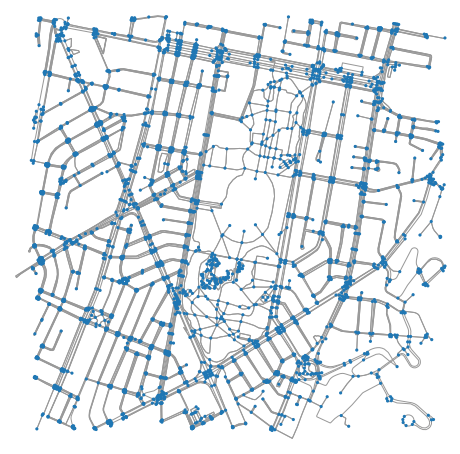

In [8]:
fig, ax = ox.plot_graph(G, figsize=(8,10), bgcolor='white', node_color='tab:blue',node_size=10)

Determinamos puntos de interés dentro de la red.

In [9]:
# Puntos de interés
## Determinamos una lista de categorías que mantendremos
amenities = ['arts_centre','building','bank','bar','bureau_de_change','cafe','car_rental','car_wash','childcare',
     'cinema','clinic','college','community_centre','conference_centre','courthouse','dentist',
     'doctors','doctors;clinic','embassy','fast_food','fast_food;college','food_court','fuel',
     'hospital','ice_cream','internet_cafe','kindergarten','language_school','marketplace',
     'nursing_home','pharmacy','place_of_worship','police','post_box','post_office','pub',
     'public_building','restaurant','school','shelter','social_facility','studio','veterinary']
## Para saber qué puntos de interés están registrados correr:
'''
df = ox.pois.pois_from_address('La Carolina, Quito, Ecuador', distance=1000)
list(set(df['amenity'][df['amenity'].notnull()].to_numpy().tolist()))

'''
## Obtenemos los puntos
#pois = ox.pois.pois_from_address('La Carolina, Quito, Ecuador', distance=1000, amenities=amenities)
#pois = ox.geometries_from_address('La Carolina, Quito, Ecuador', {a:True for a in amenities}, dist=1000)
pois = ox.geometries_from_address('Parque La Carolina, Quito, Ecuador', {'amenity':amenities}, dist=1000)
pois = pois[pois.amenity.notnull()]

/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [10]:
#pois #pois.plot(markersize=2, color='red',alpha=0.7); plt.show()

Determinamos las coordenadas de cada punto y creamos un depósito artifical, de donde esperamos que saldrán los vehículos y encuestadores.

In [11]:
POICoords = [(a.x, a.y) for a in pois['geometry'].representative_point().values]
ρ   = mean(POICoords, axis=0).tolist()
#P_ρ = ox.geo_utils.get_nearest_node(G, ρ[::-1])
#ox.distance.get_nearest_node(G, ρ[::-1])
P_ρ = ox.distance.nearest_nodes(G, ρ[0], ρ[1])

## 1<sup>era</sup> Proyección

Proyectamos todos los puntos dentro de la red usando la distancia de semiverseno.

In [12]:
POIx, POIy = asarray( list(map(list, zip(*POICoords))) )  # zip(*POICoords)

In [13]:
#POIClose = ox.get_nearest_nodes(G, POIx, POIy, method='balltree')
POIClose = ox.distance.nearest_nodes(G, POIx, POIy)

/Users/andy/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/andy/miniforge3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


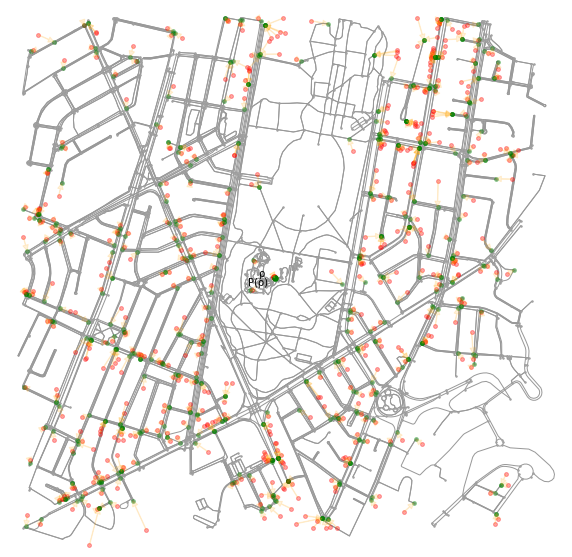

In [20]:
fig, ax = ox.plot_graph(G, figsize=(10,10), show=False, close=False, bgcolor='white',
                        node_edgecolor='#999999', node_size=2) # Incrementar para + resolución
#ax.set_facecolor('xkcd:white')

# Depósito
ax.scatter(ρ[0], ρ[1], c='red', s=30)
ax.annotate('ρ', (1.000007*ρ[0], ρ[1]))
ax.scatter(G.nodes[ P_ρ ]['x'], G.nodes[ P_ρ ]['y'],  c='green', s=30)
ax.annotate('P(ρ)', (1.000012*G.nodes[ P_ρ ]['x'], (1+.0015)*G.nodes[ P_ρ ]['y']))
ax.arrow(ρ[0], ρ[1], G.nodes[ P_ρ ]['x']-ρ[0], G.nodes[ P_ρ ]['y']-ρ[1], 
         width=0.2e-4, head_width=2e-4, head_length=2e-4,  length_includes_head=True, 
         color='orange', alpha=0.25)

for i, a in enumerate(POICoords):
    ax.scatter(a[0], a[1], c='red', s=15, alpha=0.35)
    ax.scatter(G.nodes[ POIClose[i] ]['x'], G.nodes[ POIClose[i] ]['y'],  c='green', s=15, alpha=0.35)
    ax.arrow(a[0], a[1], 
             G.nodes[ POIClose[i] ]['x']-a[0], G.nodes[ POIClose[i] ]['y']-a[1], 
             width=0.2e-4, head_width=2e-4, head_length=2e-4,  length_includes_head=True, 
             color='orange', alpha=0.15)
plt.show()

## 2<sup>da</sup> Proyección

Algunos puntos se han localizado en calles opuestas, lo cual es muy irrealista al aproximar la distancia a pie y en vehículo.

In [21]:
a = POICoords[168]

/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/andy/miniforge3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


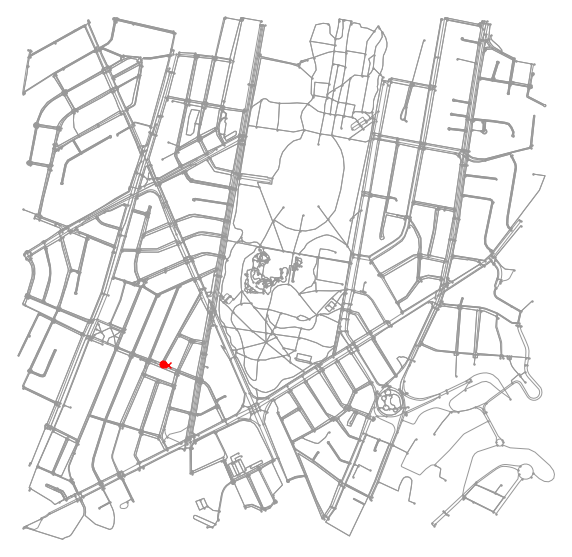

In [49]:
# Encontramos el nodo más cercano perteneciente a la arista más cercana
#geom, u, v, _ = ox.get_nearest_edge(G, (a[1], a[0]))
u, v, _ = ox.distance.nearest_edges(G, a[0], a[1])
#nn = min((u, v), key=lambda n: ox.great_circle_vec(a[1], a[0], G.nodes[n]['y'], G.nodes[n]['x']))
nn = min((u, v), key=lambda n: ox.distance.great_circle_vec(a[1], a[0], G.nodes[n]['y'], G.nodes[n]['x']))

# graficamos
fig, ax = ox.plot_graph(G, node_color='#999999', show=False, close=False, figsize=(10,10),bgcolor='white',
                        node_edgecolor='#999999', node_size=2)
ax.scatter(a[0], a[1], c='r', marker='x')
ax.scatter(G.nodes[nn]['x'], G.nodes[nn]['y'], c='r', s=50, zorder=2)
plt.show()

Pasamos a proyectar los nodos al nodo de la arista más cercana.

In [62]:
#POIElose = ox.get_nearest_edges(G, POIx, POIy, method='balltree')
POIElose = ox.distance.nearest_edges(G, POIx, POIy)
POIElose = asarray(POIElose)[:,:2]

/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/li

/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/li

/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/li

/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/li

/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/li

/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/li

/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/li

/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/distance.py:288: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy))].distance(Point(xy))
/Users/andy/miniforge3/li

In [63]:
POI_Eu = asarray([ (G.nodes[nn]['y'], G.nodes[nn]['x']) for nn in POIElose[:,0]])
POI_Ev = asarray([ (G.nodes[nn]['y'], G.nodes[nn]['x']) for nn in POIElose[:,1]])

In [75]:
#POIE = take_along_axis(POIElose, 1*(ox.great_circle_vec(POIx, POIy, POI_Eu[:,0], POI_Eu[:,1]) >= 
#                             ox.great_circle_vec(POIx, POIy, POI_Ev[:,0], POI_Ev[:,1]))[:,None], axis=1).ravel()
POIE = take_along_axis(POIElose, 1*(ox.distance.great_circle_vec(POIx, POIy, POI_Eu[:,0], POI_Eu[:,1]) >= 
                                    ox.distance.great_circle_vec(POIx, POIy, POI_Ev[:,0], POI_Ev[:,1]))[:,None], 
                       axis=1).ravel()

/Users/andy/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/andy/miniforge3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


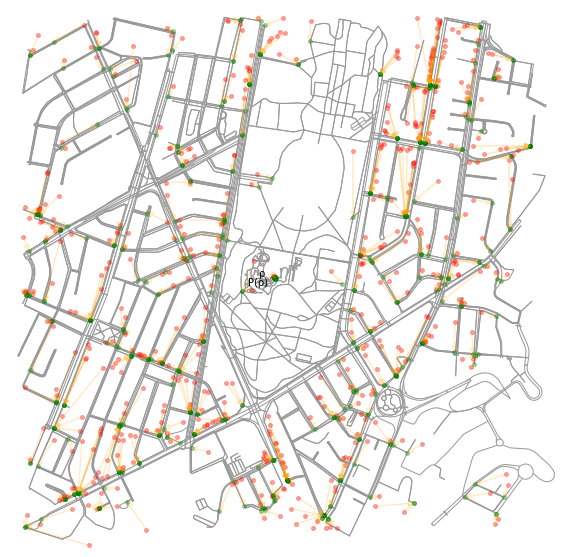

In [79]:
fig, ax = ox.plot_graph(G, figsize=(10,10), show=False, close=False,bgcolor='white',
                        node_edgecolor='#999999', node_size=0) # Incrementar para + resolución

# Depósito
ax.scatter(ρ[0], ρ[1], c='red', s=30)
ax.annotate('ρ', (1.000007*ρ[0], ρ[1]))
ax.scatter(G.nodes[ P_ρ ]['x'], G.nodes[ P_ρ ]['y'],  c='green', s=30)
ax.annotate('P(ρ)', (1.000012*G.nodes[ P_ρ ]['x'], (1+.0015)*G.nodes[ P_ρ ]['y']))
ax.arrow(ρ[0], ρ[1], G.nodes[ P_ρ ]['x']-ρ[0], G.nodes[ P_ρ ]['y']-ρ[1], 
         width=0.2e-4, head_width=2e-4, head_length=2e-4,  length_includes_head=True, 
         color='orange', alpha=0.25)

α = 0
for i, a in enumerate(POICoords[α:]):
    ax.scatter(a[0], a[1], c='red', s=15, alpha=0.35)
    ax.scatter(G.nodes[ POIE[α+i] ]['x'], G.nodes[ POIE[α+i] ]['y'],  c='green', s=15, alpha=0.35)
    ax.arrow(a[0], a[1], 
             G.nodes[ POIE[α+i] ]['x']-a[0], G.nodes[ POIE[α+i] ]['y']-a[1], 
             width=0.2e-4, head_width=2e-4, head_length=2e-4,  length_includes_head=True, 
             color='orange', alpha=0.15)
plt.show()

## 3<sup>ra</sup> proyección

Notemos que en lo anterior, si bien ahora no hay puntos que están en calles opuestas, todavía hay puntos que son proyectados o muy lejos de la arista o en puntos que gráficamente no corresponden. Así, una mejor idea es proyectar los puntos en la arista más cercana, tomaremos ideas de [1](https://towardsdatascience.com/connecting-pois-to-a-road-network-358a81447944) y [2](https://github.com/ywnch/toolbox).

```Puedes saltarte las primeras dos proyecciones hasta este punto :)```


In [12]:
amenities = ['arts_centre','bank','bar','bureau_de_change','cafe','car_rental','car_wash','childcare',
     'cinema','clinic','college','community_centre','conference_centre','courthouse','dentist',
     'doctors','doctors;clinic','embassy','fast_food','fast_food;college','food_court','fuel',
     'hospital','ice_cream','internet_cafe','kindergarten','language_school','marketplace',
     'nursing_home','pharmacy','place_of_worship','police','post_box','post_office','pub',
     'public_building','restaurant','school','shelter','social_facility','studio','veterinary']
## Obtenemos los puntos
#pois = ox.pois.pois_from_address('La Carolina, Quito, Ecuador', distance=1000, amenities=amenities)
pois = ox.geometries_from_address('Parque La Carolina, Quito, Ecuador', {'amenity':amenities}, dist=1000)
pois = pois[pois.amenity.notnull()]
pois['geometry'] = pois['geometry'].representative_point()
pois['lon'] = pois['geometry'].apply(lambda p: p.x)
pois['lat'] = pois['geometry'].apply(lambda p: p.y)
pois = pois.reset_index(level=['element_type','osmid'])
pois['key'] = pois.osmid  # set a primary key column'''

/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/Users/andy/miniforge3/lib/python3.9/site-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


In [13]:
nodes, edges = ox.graph_to_gdfs(G)

In [14]:
nodes = nodes.reset_index(level=['osmid'])
nodes.head()

,osmid,y,x,highway,street_count,geometry
0,262137674,-0.177828,-78.488922,traffic_signals,3,POINT (-78.48892 -0.17783)
1,262137675,-0.182325,-78.490126,NaN,4,POINT (-78.49013 -0.18232)
2,262190235,-0.191678,-78.493406,NaN,4,POINT (-78.49341 -0.19168)
3,262190237,-0.190283,-78.494320,NaN,4,POINT (-78.49432 -0.19028)
4,262190239,-0.190877,-78.493078,traffic_signals,3,POINT (-78.49308 -0.19088)


In [15]:
edges = edges.reset_index(level=['u','v','key'])
edges['from'] = edges['v']
edges['to'] = edges['u']

In [16]:
edges.head(3)

,u,v,key,osmid,oneway,name,highway,access,length,lanes,maxspeed,geometry,junction,tunnel,bridge,width,ref,service,from,to
0,262137674,8986320900,0,898070449,False,Mañosca,tertiary,yes,10.180,NaN,NaN,"LINESTRING (-78.48892 -0.17783, -78.48901 -0.1...",NaN,NaN,NaN,NaN,NaN,NaN,8986320900,262137674
1,262137674,9627871462,0,427683987,True,Avenida 10 de Agosto,primary,NaN,67.308,3,50,"LINESTRING (-78.48892 -0.17783, -78.48902 -0.1...",NaN,NaN,NaN,NaN,NaN,NaN,9627871462,262137674
2,262137675,9077977998,0,24209692,True,Avenida 10 de Agosto,primary,NaN,50.573,3,50,"LINESTRING (-78.49013 -0.18232, -78.49026 -0.1...",NaN,NaN,NaN,NaN,NaN,NaN,9077977998,262137675


In [17]:
#import sys, importlib
#importlib.reload(sys.modules['connect_poi'])
from connect_poi      import connect_poi
from shapely.geometry import Point, LineString

In [18]:
new_nodes, new_edges = connect_poi(pois, nodes, edges, key_col='key', path=None, threshold=200, knn=5)

Construyendo rtree...
Actualizando nodos externos...
Proyectando POIs a la red...
Actualizando nodos internos...
Actualizando aristas internas...


/Users/andy/miniforge3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/andy/Library/Mobile Documents/com~apple~CloudDocs/Coding/INEC/connect_poi.py:81: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  new_lines = list(split(line, pps))  # split into segments
/Users/andy/Library/Mobile Documents/com~apple~CloudDocs/Coding/INEC/connect_poi.py:81: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  new_lines = list(split(line, pps))  # split into segments


Actualizando enlaces externos...
Eliminando proyecciones fallidas: 0/542 (0.00%)
** Nota **: duplicación en llaves de coordenadas para los nodos
Número de nodos: 4522
Número de llaves de coordenadas: 4513
Nodos 'from' perdidos: 0
Nodos 'to' perdidos:   0


El resultado de aplicar la función anterior es una nueva red, descrita como un conjunto de hojas de datos, a la cual se han añadido _brevemente_ los nodos que queríamos agregar a la red, un nodo en el arco más cercano y un arco desde el nodo de interés hacia la calle.

/Users/andy/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/andy/miniforge3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/andy/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/andy/miniforge3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/andy/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:7

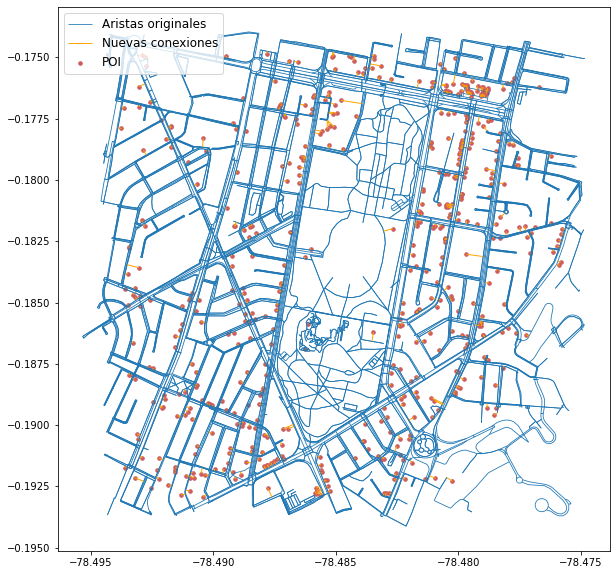

In [19]:
poi_links = new_edges[new_edges['highway'] == 'projected_footway']

ax = edges.plot(linewidth=0.8, figsize=(18,10),       label='Aristas originales')
poi_links.plot(color='orange', linewidth=1, ax=ax, label='Nuevas conexiones')
pois.plot(color='indianred', marker='.', markersize=50, ax=ax, label='POI')
ax.legend(loc=2, fontsize=12)
plt.show()

Sin embargo, las hojas de datos entregadas no pueden formar un grafo formalmente, para ello realizamos el siguiente post-procesamiento.

In [20]:
#nodes.gdf_name

In [21]:
# La función crea nuevos campos en el pandas que no constaban previamente, así que aquí se corrige la información
new_edges['u'] = where(new_edges['from'].notnull(), new_edges['from'], new_edges['u']).astype('int64',copy=False)
new_edges['v'] = where(new_edges['to'].notnull(),   new_edges['to'],   new_edges['v']).astype('int64',copy=False)
new_edges['oneway'] = where(new_edges['to'].notnull(), True,   new_edges.oneway)

new_edges.drop('from', axis=1, inplace=True)
new_edges.drop('to',   axis=1, inplace=True)

In [22]:
new_edges.key   = 0
new_nodes.osmid = new_nodes.osmid.astype('int64', copy=False)
new_nodes.index = new_nodes.index.astype('int64', copy = False)
new_nodes.replace('projected_pap', np.NaN, inplace=True)
new_edges.replace('projected_footway', 'residential', inplace=True)

Con lo anterior ya podemos trazar la red y almacenarla como un grafo dirigido.

In [23]:
new_nodes.head()

,osmid,y,x,highway,street_count,geometry
osmid,,,,,,
262137674,262137674,-0.177828,-78.488922,traffic_signals,3.0,POINT (-78.48892 -0.17783)
262137675,262137675,-0.182325,-78.490125,NaN,4.0,POINT (-78.49013 -0.18232)
262190235,262190235,-0.191678,-78.493406,NaN,4.0,POINT (-78.49341 -0.19168)
262190237,262190237,-0.190283,-78.494320,NaN,4.0,POINT (-78.49432 -0.19028)
262190239,262190239,-0.190877,-78.493078,traffic_signals,3.0,POINT (-78.49308 -0.19088)


In [24]:
new_edges = new_edges.set_index(['u', 'v', 'key'])
new_edges.head(3)

,,,osmid,oneway,name,highway,access,length,lanes,maxspeed,geometry,junction,tunnel,bridge,width,ref,service
u,v,key,,,,,,,,,,,,,,,
8986320900,262137674,0,898070449,True,Mañosca,tertiary,yes,10.180,NaN,NaN,"LINESTRING (-78.48892 -0.17783, -78.48901 -0.1...",NaN,NaN,NaN,NaN,NaN,NaN
9627871462,262137674,0,427683987,True,Avenida 10 de Agosto,primary,NaN,67.308,3,50,"LINESTRING (-78.48892 -0.17783, -78.48902 -0.1...",NaN,NaN,NaN,NaN,NaN,NaN
9077977998,262137675,0,24209692,True,Avenida 10 de Agosto,primary,NaN,50.573,3,50,"LINESTRING (-78.49013 -0.18232, -78.49026 -0.1...",NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
'''
gdf_nodes (geopandas.GeoDataFrame) – GeoDataFrame of graph nodes uniquely indexed by osmid
gdf_edges (geopandas.GeoDataFrame) – GeoDataFrame of graph edges uniquely multi-indexed by u, v, key
'''
GG = ox.graph_from_gdfs(new_nodes, new_edges)

/Users/andy/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/andy/miniforge3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


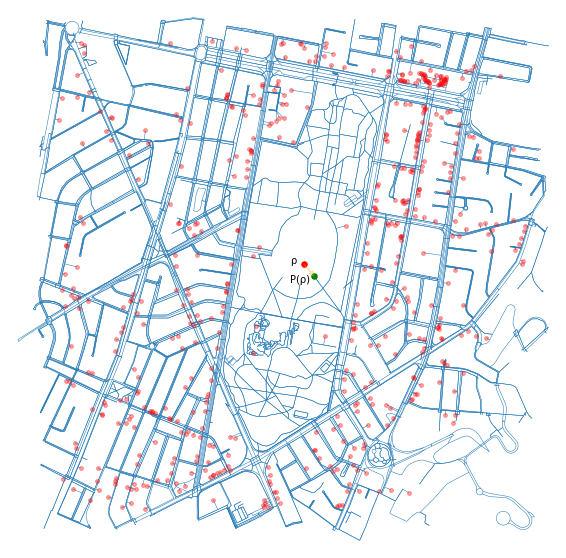

In [26]:
fig, ax = ox.plot_graph(GG, figsize=(10,10), show=False, close=False,  edge_linewidth=0.5,
                        bgcolor='white', edge_color='tab:blue',node_size=0)
# Depósito
ax.scatter(ρ[0], ρ[1], c='red', s=30)
ax.annotate('ρ', (1.000007*ρ[0], ρ[1]))
ax.scatter(GG.nodes[ P_ρ ]['x'], GG.nodes[ P_ρ ]['y'],  c='green', s=30)
ax.annotate('P(ρ)', (1.000012*GG.nodes[ P_ρ ]['x'], (1+.0015)*GG.nodes[ P_ρ ]['y']))
ax.arrow(ρ[0], ρ[1], GG.nodes[ P_ρ ]['x']-ρ[0], GG.nodes[ P_ρ ]['y']-ρ[1], 
         width=0.2e-4, head_width=2e-4, head_length=2e-4,  length_includes_head=True, 
         color='orange', alpha=0.25)

for i, a in enumerate(POICoords[0:]):
    ax.scatter(a[0], a[1], c='red', s=15, alpha=0.35)

plt.show()

Sin embargo, hay un error no contemplado hasta ahora: No hay arco de regreso en la red desde el nodo de interés hacia su proyección en la red. Es decir, hay como salir del punto pero no ingresar. 

In [27]:
nx.has_path(GG, list(GG.edges(pois.osmid.values[0]))[0][1], pois.osmid.values[0])

False

Para corregir esto, añadimos los arcos inversos.

In [28]:
new_edges = new_edges.reset_index(level=['u','v','key'])

In [29]:
ct = list(new_edges.columns.values)
ct[0], ct[1] = ct[1], ct[0]

In [30]:
below = new_edges[new_edges.u.isin(pois.osmid)].copy().reindex(columns=ct, copy=False)

In [31]:
below.columns.values[[0, 1]] = ['u', 'v']
below.osmid = below.osmid.apply(lambda x: x[::-1])
below.geometry = below.geometry.apply(lambda x: LineString(x.coords[::-1]) )
#new_edges = new_edges.set_index(['u', 'v', 'key'])

La red resultante ya incluye estos arcos.

In [32]:
Extended_Edges = pd.concat([new_edges,below],ignore_index=True)

In [33]:
GGG = ox.graph_from_gdfs(new_nodes, Extended_Edges.set_index(['u', 'v', 'key']))
#new_edges.append(below, ignore_index=True)

/Users/andy/miniforge3/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/andy/miniforge3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


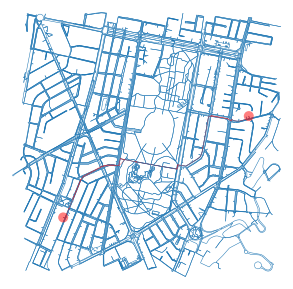

In [35]:
route = nx.shortest_path(GGG, 426846563, np.random.choice(pois.osmid), weight='length')
ox.plot_graph_route(GGG, route, figsize=(5,10), node_size=0.1,edge_linewidth=0.5,route_linewidth=0.5,
                    bgcolor='white', edge_color='tab:blue')
plt.show()

Sin embargo, es posible que no todos los puntos puedan conectarse todavía.

In [36]:
un_pois = (GGG.nodes - max(nx.strongly_connected_components(GGG), key=len)) & set(pois.osmid.values)

In [37]:
POI = pois[~pois.osmid.isin(un_pois)]

In [38]:
routes = [nx.shortest_path(GGG, POI.osmid.values[0], a, weight='length') for a in POI.osmid]

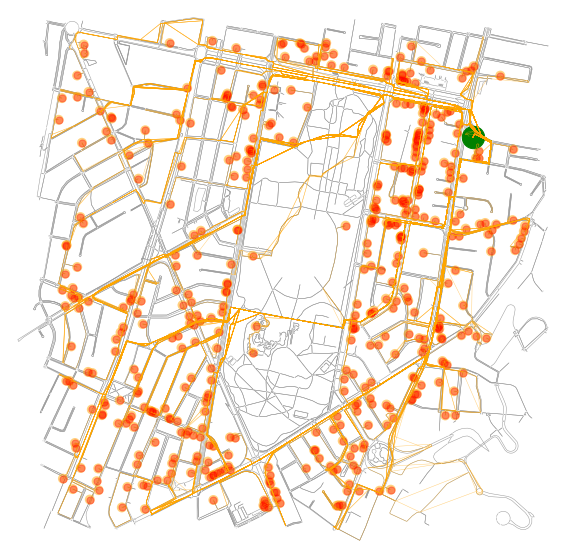

In [41]:
fig, ax = ox.plot_graph_routes(GGG, routes, figsize=(10,10),
                     edge_linewidth=0.5, route_linewidths = [0.5]*len(routes), 
                               node_size = 1, 
                               route_colors='orange',
                               show=False, close=False, bgcolor='white')

ax.scatter(POI.lon.values, POI.lat.values, c='r', s=50, alpha=0.35)
ax.scatter(POI.lon.values[0], POI.lat.values[0], c='green', s=500)
plt.show()

Con esta información ya estamos listos para determinar las matrices de caminos más cortos y hacer un muestreo aleatorio para crear subinstancias.

Para ello procederemos a guardar la información de los puntos más accesibles en la red total. Estos puntos serán proyectados en las redes vehiculares y de caminata, eventualmente.

In [42]:
POI[['osmid', 'geometry','amenity','name','lon','lat']].to_file('poi.gpkg')

In [43]:
import geopandas as gp

In [44]:
gp.read_file('poi.gpkg')

,osmid,amenity,name,lon,lat,geometry
0,346384464,restaurant,Oh Qué Bueno Más,-78.477771,-0.178577,POINT (-78.47777 -0.17858)
1,346384882,bank,Citi Ecuador,-78.479203,-0.177675,POINT (-78.47920 -0.17767)
2,348028951,cinema,Multicines,-78.484794,-0.176749,POINT (-78.48479 -0.17675)
3,348042041,arts_centre,Centro Artístico Don Bosco,-78.492447,-0.187668,POINT (-78.49245 -0.18767)
4,348044623,arts_centre,Galería Catasse,-78.479657,-0.186364,POINT (-78.47966 -0.18636)
...,...,...,...,...,...,...
462,667975764,fast_food,Korfu,-78.480486,-0.176377,POINT (-78.48049 -0.17638)
463,667975765,fast_food,Dunkin' Donuts,-78.480421,-0.176385,POINT (-78.48042 -0.17639)
464,667975766,restaurant,El Español,-78.480329,-0.176398,POINT (-78.48033 -0.17640)
465,668311651,cafe,Sweet & Coffee,-78.478197,-0.176276,POINT (-78.47820 -0.17628)


Si quisieramos determinar la longitud del camino más corto entre todos los nodos, podríamos modificar el siguiente código:

In [45]:
[nx.shortest_path_length(GGG, POI.osmid.values[0], a, weight='length') for a in POI.osmid.values[:10]]

[0,
 465.7075118153291,
 1854.1296551759347,
 3002.0991288188525,
 1147.911178483501,
 821.6716303361983,
 944.3023013299671,
 891.9149812100839,
 1706.397130226019,
 2600.860751944402]

Haremos el muestreo y las respectivas proyecciones en otro cuadernillo, sin embargo, aquí podemos visualizar los cambios en la red respecto a redes vehiculares y pedestres.

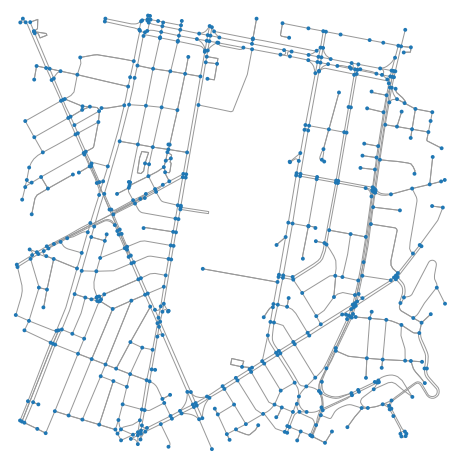

In [51]:
g = ox.graph_from_address('Parque La Carolina, Quito, Ecuador', dist=1000, simplify=True, 
                          network_type='drive_service')
ox.plot_graph(g, figsize=(8,10),bgcolor='white', node_color='tab:blue'); plt.show()

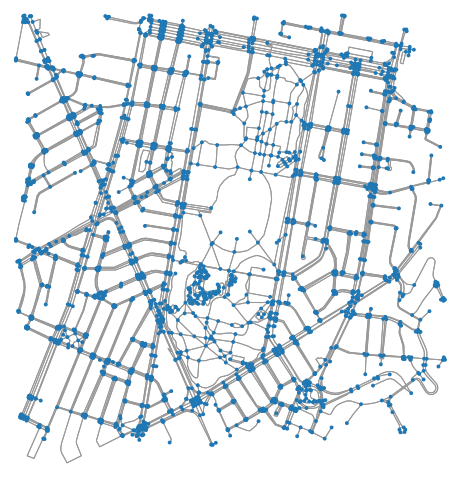

In [52]:
g = ox.graph_from_address('Parque La Carolina, Quito, Ecuador', dist=1000, simplify=True, network_type='walk')
ox.plot_graph(g, figsize=(8,10), bgcolor='white', node_color='tab:blue'); plt.show()

In [53]:
nx.is_strongly_connected(g)

True

Más información de `OSMnx` puede encontrarse en la documentación en [readthedocs](https://osmnx.readthedocs.io/en/stable/osmnx.html), en este [blog](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) o en su [git](https://github.com/gboeing/osmnx).

También hay [tutoriales](https://github.com/gboeing/osmnx-examples) en [binder](https://mybinder.org/v2/gh/gboeing/osmnx-examples/master).

### Visualización con folium

In [54]:
import folium

In [55]:
# para graficar todo usar: https://stackoverflow.com/questions/49546015/osmnx-visualize-the-graph-of-edge-centrality-on-folium
δ = ox.plot_route_folium(GGG, route, route_color='green')
folium.Marker(location=(POI[POI.osmid == route[0]].lat.values[0], POI[POI.osmid == route[0]].lon.values[0]),
              icon=folium.Icon(color='red')).add_to(δ)
folium.Marker(location=(POI[POI.osmid == route[-1]].lat.values[0], POI[POI.osmid == route[-1]].lon.values[0]),
              icon=folium.Icon(color='blue')).add_to(δ)
δ

### Dirección y movilidad

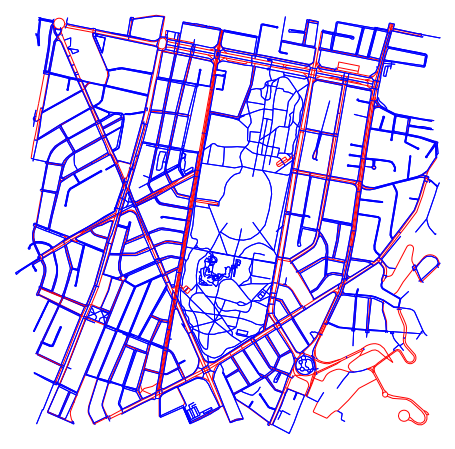

In [56]:
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in G.edges(keys=True, data=True)]
ox.plot_graph(G, node_size=0, edge_color=ec, bgcolor='white')
plt.show()

# Otros

In [ ]:
#from pandana.loaders import osm                 # para usar este paquete se necesita conocer coordenadas
# define your selected amenities and bounding box
#amenities = ['fast_food','restaurant','clinic','dentist','bank','community_centre',
#                         'cafe','pharmacy','bar','kindergarten','atm','hospital']
#bbox = [-0.1902507, -78.4906032, -0.1861195, -78.4849880]                 # found w/ https://overpass-turbo.eu/#
# To check available amenities run:
'''
df = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3])
list(set(df['amenity'][df['amenity'].notnull()].to_numpy().tolist()))

'''
# request them from the OpenStreetMap API (Overpass)
#pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3])
#pois = pois[pois['amenity'].isin(amenities)]

In [ ]:
#bbox = ox.core.bbox_from_point(ν, distance=1000); bbox

In [ ]:
#GGG.edges(406032130)

In [ ]:
{a for a in POI.osmid if not nx.has_path(GGG, POI.osmid.values[0], a)}
start = time.time()
un_pois = [{a for a in POI.osmid if not nx.has_path(GGG, b, a)} for b in POI.osmid ]
end   = time.time()
print(end-start)
set([item for subdict in un_pois for item in subdict ])

In [180]:
#POI[['osmid','amenity','name','lon','lat']].to_excel('poi.xlsx')

In [183]:
#pd.read_excel('poi.xlsx', index_col=0)

In [187]:
#pois.to_file('pp.shp')

In [195]:
#POI[['osmid', 'geometry','amenity','name','lon','lat']].to_file('pp.shp')